In [1]:
import pynbody
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy import optimize
from astropy import units as unit
import sys

In [30]:
datadir = '/media/juan/Pesquisa/Pesquisa/SNAPSHOTS'
#datadir = '/home/danna01/Desktop/Auxiliatura/Galaxias'
#data_nuevo = "̣/home/danna01/Desktop/Auxiliatura/Galaxias_Nuevas"
#data_viejo = "̣/home/danna01/Desktop/Auxiliatura/Galaxias_Viejas"

#En esta celda generamos el diccionario para los valores de las galaxias y los limites
#Los limites son diferenciados porque el plot utilizara unos valores y los limites de h serán más
#restringidos con el objetivo de mejorar el valor de 'h' y a su vez no perder informacion.

galaxies = ['G0', 'G1']#, 'G2','G3']
limites_densidad = {'G0':(0,20), 'G1':(0,25), 'G2':(0,20), 'G3':(0,55)}
limites = {'G0':(2,6),'G1':(10,15),'G2':(5,10),'G3':(30,40)}

minsnap = 100
maxsnap = 601
stepsnap = 200

## 1. Las siguientes celdas definen las funciones para graficar los perfiles de densidad y ajustarlos a una recta

In [3]:
# El scale-length del disco de gas
# El scale-length del disco estelar

In [4]:
# Radial surface density of the disk
#Hacer limites diferenciados
def density(pos,mass,n,limits):
    r       = np.sqrt((pos[:,:2]**2).sum(axis=1)) # Azymutal radius 
    histo   = np.histogram(r,n,range=limits)
    #plt.hist(r,n,range=limits)
    bins     = (histo[1][:-1]+histo[1][1:])/2
    bn_mass = np.zeros(n)
    #Aca sacamos la sumatoria de la masa que esta concentrada en cada una de las barras del histograma.
    for i in range(n):
            bn_mass[i]      = mass[(r >= histo[1][i])*(histo[1][i+1] > r)].sum()
    dens    = bn_mass/(np.pi)/((histo[1][1:])**2-(histo[1][:-1])**2)
    return histo,bins,dens

In [5]:
#esta celda es necesaria para calcular el error cuadrado mínimo para hallar la linea recta que se ajuste
#mejor a los datos obtenidos para la densidad superficial
def fit_exponential(x,y,limits):
    mask = (x >= limits[0])*(x <= limits[1])
    x = x[mask]
    y = y[mask]
    y = np.log10(y)
    # initial guess (punto inicial aproximado necesario para que la funcion de minimo cuadrado pueda funcionar)
    m_0 = (y[-1] - y[0])/(x[-1] - x[0])
    b_0 = y[0] - m_0*x[0]
    errfun  = lambda p: np.ravel(p[0]*x[:]+p[1]-y[:])
    fitparam = optimize.leastsq(errfun,[m_0,b_0],full_output=1)[0]
    m = fitparam[0]
    b = fitparam[1]
    return m,b

In [6]:
#esta celda simplemente funciona para definir todos los parametros de las graficas que son generadas para cada 
#snapshot y pues para cada tipo de dato (estrella, gas, etc.)
def plot_exponential(bins,dens,m,b,filename):
    R = (-1./m)*np.log10(np.e)
    fig = plt.figure(figsize=(10, 7))
#importante: el calculo del valor de 'h'
    plt.plot(bins, np.log10(dens), 'r.', Label = 'h = {a:3.2f}'.format(a = R))
    plt.plot(bins,m*bins+b,'-k')
    plt.legend(fontsize = 20, loc=0)
    plt.title('Perfil de densidad superficial', fontsize = 18)
    plt.xlabel('Radio [Kpc]', fontsize = 20)
    plt.ylabel(r'$\rho$ [$1x10^{10}$ Msol/$kpc^{2}$]', fontsize = 20)
    plt.grid()
    plt.savefig(filename)
    plt.clf()
    plt.close()

## 2. Estas funciones calculan la curva de rotación de las partículas de gas, y su máximo

In [7]:
# Radio azimutal 
def RGas(data):
    Rg = np.sqrt(data.gas['pos'][:,0]**2 + data.gas['pos'][:,1]**2)
    return Rg

In [8]:
# Velocidad tangencial
def Vcartesian2polar(pos,vel):
    Vtan    = np.zeros(pos.shape[0])
    Vrad    = np.zeros(pos.shape[0])
    norm    = np.sqrt(pos[:,0]**2+pos[:,1]**2)
    Vtan    = (vel[:,1]*pos[:,0]-vel[:,0]*pos[:,1])/norm
    Vrad    = (vel[:,0]*pos[:,0]+vel[:,1]*pos[:,1])/norm
    return Vtan,Vrad

In [9]:
# Dada una secuencia de puntos, que serán los extremos
# de las casillas de los bins de un histograma, saca los puntos medios
# de cada casilla como referencia
def radios(points):
    radii     = (points[:-1]+points[1:])/2
    return radii 

In [10]:
# Función que retorna la curva de rotación para las partículas
# de gas en una galaxia tipo disco en rotación. 
# Lo hace con bins circulares, tomando en cada bin la media de
# las velocidades tangenciales, pero ponderada por la masa de cada partícula
# Es decir, en cada bin define:
# <V_cir> = Sum(V_tan * mass) / Sum(mass)

def RotCurvGas(data,points):
    a = np.histogram(RGas(data), bins=points,  weights= Vcartesian2polar(data.gas["pos"],data.gas["vel"])[0]*data.gas['mass'])
    b = np.histogram(RGas(data), bins=points,  weights= data.gas['mass'])
    Vel = (a[0]/b[0])
    return a[1][0:len(points)-1],Vel

In [11]:
# Calcula la curva de rotacion, la grafica y almacena la figura
# Returna el valor máximo de la curva de rotación
def plot_rot_curve(gal,data,filename):
    r_bins = np.arange(limites_densidad['G0'][0],limites_densidad['G0'][1],0.5)
    Vel = RotCurvGas(data,r_bins)[1]
    r = radios(r_bins)
    plt.plot(r,Vel)
    
    fig = plt.figure(figsize=(10, 7))
    plt.plot(r,Vel)
    plt.title('Curva de rotación del gas', fontsize = 18)
    plt.xlabel('Radio [Kpc]', fontsize = 20)
    plt.ylabel(r'V_{circular}$ [km / s]', fontsize = 20)
    plt.grid()
    plt.savefig(filename)
    plt.clf()
    plt.close()
    
    return np.nanmax(Vel)

## Las siguientes funciones compilan la información para todos los snapshots de una cierta galaxia

In [34]:
def compile_data(origin,gal,minsnap,maxsnap,stepsnap):
    dicti = {}
    for snap in np.arange(minsnap,maxsnap,stepsnap): 
        try:
            snap = str(snap).zfill(3)
        
            data = pynbody.load(origin+'/'+gal+'/'+gal+'_snapshot_'+snap+'.hdf5')
            dicti[snap] = {}
            
            # ESTO ES NUEVO, PARA SABER LA VELOCIDAD MÁXIMA DE LA CURVA DE ROTACIÓN
            V_max = plot_rot_curve(gal,data,filename='plots_old/'+gal+'_rotcurve_'+snap+'.jpg')
            dicti[snap]['Vmax'] = V_max
            
            N_star = data.star['mass'].size
            dicti[snap]['Nstar'] = N_star

            histo,bins,dens = density(data.gas['pos'],data.gas['mass'],n=20,limits=limites_densidad[gal])
            m,b = fit_exponential(bins,dens,limits=limites[gal])
            plot_exponential(bins,dens,m,b,filename='plots_old/'+gal+'_gas_'+snap+'.jpg')
            dicti[snap]['h_gas'] = -1/m*np.log10(np.e)
        
            histo,bins,dens = density(data.star['pos'],data.star['mass'],n=20,limits=limites_densidad[gal])
            m,b = fit_exponential(bins,dens,limits=limites[gal])
            plot_exponential(bins,dens,m,b,filename='plots_old/'+gal+'_star_'+snap+'.jpg')
            dicti[snap]['h_star'] = -1/m*np.log10(np.e)
            
        except:
            continue
            
    return dicti

In [19]:
# Finalizada la compilación de datos en un diccionario
# Aqui se extraen los valores de cada cantidad secuencialmente
def extract_qtt(dictionary,quantity):
    if quantity == 'snapshots':
        lista = [np.float(key) for key in dictionary.keys()]
    else:
        # list comprehension
        lista = [dictionary[str(snap).zfill(3)][quantity] for snap in dictionary.keys()]
    return lista

In [25]:
def show_results(dicti,gal):
    snapshots = extract_qtt(dicti,'snapshots')
    print(snapshots)
    h0_gas = extract_qtt(dicti,'h_gas')
    print(h0_gas)
    h0_star = extract_qtt(dicti,'h_star')
    N_star = extract_qtt(dicti,'Nstar')
    Vmax = extract_qtt(dicti,'Vmax')
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(131)
    #plt.hist(h0_gas,bins=5,color='green')
    plt.plot(snapshots,h0_gas,"og")
    plt.title(gal + '  h0 GAS')
    
    #plt.figure()
    plt.subplot(132)
    #plt.hist(h0_star,bins=5,color='orange')
    plt.plot(snapshots,h0_star,"oy")
    plt.title(gal + '  h0 STARS')
    
    plt.subplot(133)
    #plt.hist(Vmax,bins=5,color='red')
    plt.plot(snapshots,Vmax,"oy")
    plt.title(gal + '  Max Velocity')

/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(
<ipython-input-6-e4adf6b69db9>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(bins, np.log10(dens), 'r.', Label = 'h = {a:3.2f}'.format(a = R))
<ipython-input-6-e4adf6b69db9>:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(bins, np.log10(dens), 'r.', Label = 'h = {a:3.2f}'.format(a = R))
<ipython-input-6-e4adf6b69db9>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(bins, np.log10(dens), 'r.', Label = 'h = {a:3.2f}'.format(a 

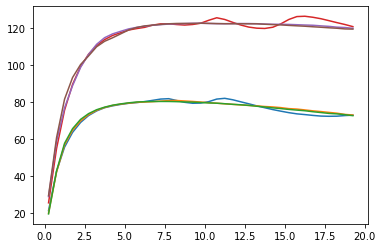

In [31]:
super_dict = {}
for gal in galaxies:
    super_dict[gal] = compile_data(datadir,gal,minsnap,maxsnap,stepsnap)

In [32]:
super_dict

{'G0': {'100': {'Vmax': 82.13891,
   'Nstar': 201908,
   'h_gas': 3.4259070033142827,
   'h_star': 0.9824831232893075},
  '300': {'Vmax': 80.967255,
   'Nstar': 207039,
   'h_gas': 3.9511447633615058,
   'h_star': 1.0332494387211888},
  '500': {'Vmax': 80.44825,
   'Nstar': 210399,
   'h_gas': 4.2470257896683075,
   'h_star': 1.0411919917452719}},
 'G1': {'100': {'Vmax': 126.5528,
   'Nstar': 317536,
   'h_gas': 5.921156005794261,
   'h_star': 2.1136594340226726},
  '300': {'Vmax': 122.754364,
   'Nstar': 328074,
   'h_gas': 4.171571746121696,
   'h_star': 1.5418270566901575},
  '500': {'Vmax': 122.78294,
   'Nstar': 334837,
   'h_gas': 4.126982338363898,
   'h_star': 1.3743915983246386}}}

[100.0, 300.0, 500.0]
[3.4259070033142827, 3.9511447633615058, 4.2470257896683075]
[100.0, 300.0, 500.0]
[5.921156005794261, 4.171571746121696, 4.126982338363898]


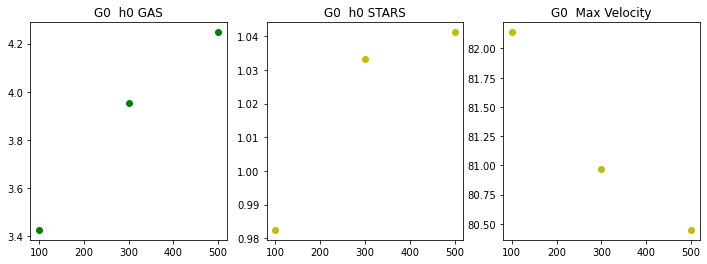

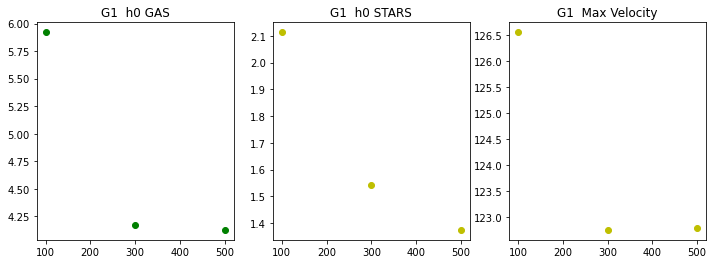

In [35]:
for gal in galaxies:
    show_results(super_dict[gal],gal)

In [29]:
show_results(super_dict['G0'],'G0')

[100.0, 200.0, 300.0, 400.0, 500.0, 600.0]


KeyError: 'h_gas'

In [ ]:
# Con estas líneas vamos a salvar el diccionario directamente en un formato de python
# para que las próximas veces podamos simplemente leerlo, sin tener que volver a
# hacer toooda la compilación leyendo directo de los snapshots
# Va a quedar guardado con el numbre de archivo: 'compilation'
import pickle

file = open('compilation_old', 'wb')
pickle.dump(super_dict, file)
file.close()


In [ ]:
# Así lo leemos después de haberlo almacenado
# Va a quedar importado en la variable 'dictionary_cargado'
file = open('compilation_old', 'rb')
dictionary_cargado = pickle.load(file)
file.close()